# K-Means Clustering

Clustering refers to an *unsupervised* learning algorithms that partition data into groups by similarity. Clustering can be used to identify categories from and assign classes/labels to unlabeled data (perhaps for classification).

We'll only introduce K-means clustering, but alternative clustering methods include:

 - DBScan (Density-Based Spacial Clustering of Applications with Noise)
 - Agglomerative Clustering (Hierarchical Clustering)

### An Example with Synthetic Data

To demonstrate K-Means, we'll first create a synthetic dataset of 5 clusters using the sklearn make_blobs function. Remember, because we create this dataset, we know it should have 5 clusters. BUT that does not mean that the best partitioning will be into 5 groupings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_samples, silhouette_score

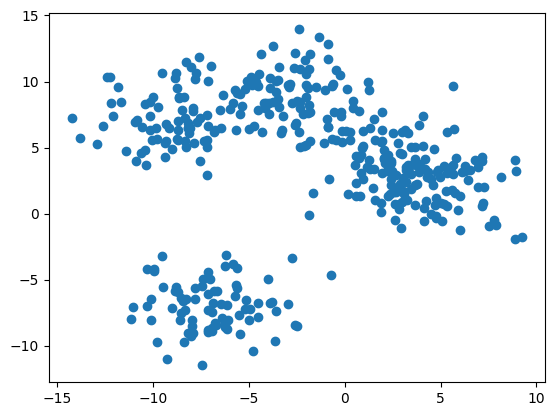

In [2]:
X = make_blobs(n_samples = 400, n_features = 2, centers = 5, cluster_std = 2, random_state=42)
X = X[0]
plt.scatter(X[:,0],X[:,1])
plt.show()

If we squint at the data above, we see two clear groupings, and possibly 3 or 4. Two of the clusters have melded into a single blob.

So how do we know how many groupings there should be?

**Silhouette Score**

Silhouette Score assigns a number to each data point that describes how similar it is to the other members of its group. Silhouette score ranges from [-1, 1].

 - *0 < score < 1* - the data point is more like its own group than any other
 - *score = 0* - the data point is on the boundary between belonging to one of two (or more) groups
 - *-1 < score < 0* - the data point is likely in the wrong group

Since we are not classifying unknown data, all of our scores will be in the [0, 1] range. We take the average of all silhouette scores to assess the clustering. A general guideline for assessing groupings:

 - *score > 0.75* - high confidence in groupings
 - *0.5 < score < 0.75* - good confidence in groupings
 - *0 < score < 0.5* - weak confidence in groupings

**K-Means**

K-Means takes as a hyper-parameter the number of groupings to assign to the data. We'll try several values, calculating the silhouette score for each. We choose the partitioning with the highest silhouette score.

Once we've picked our best model, we inspect the cluster assignments and cluster centers (centroids).

 - ```km.labels_``` - an array assigning each data point to the cluster it belongs to
 - ```km.cluster_centers_``` - an array of the center point of each cluster

Let's see this in action...

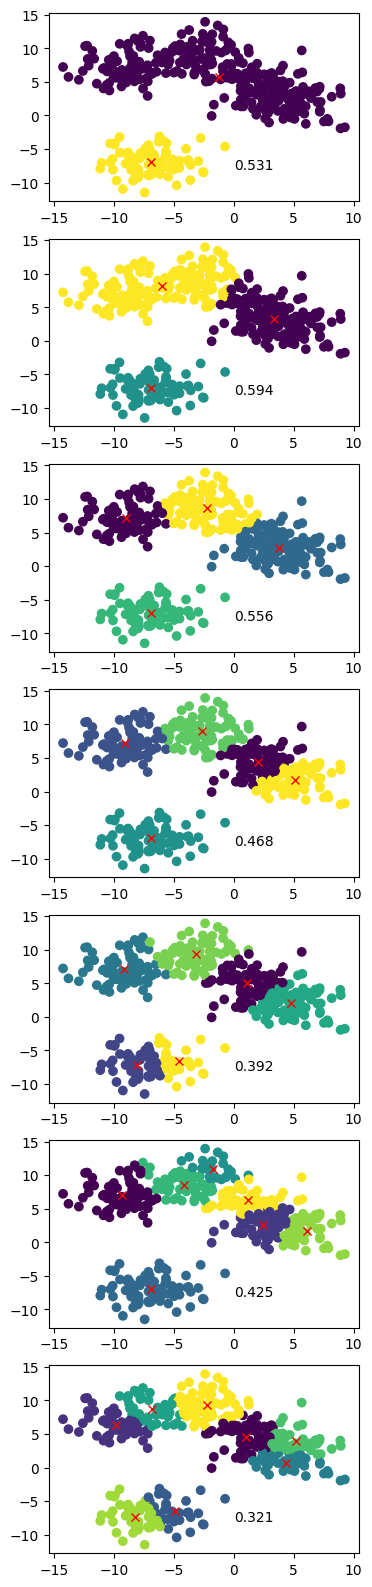

In [3]:
# Define the list of cluster numbers to evaluate
n_clusters = [2, 3, 4, 5, 6, 7, 8]

scores = []

fig, ax = plt.subplots(len(n_clusters), 1, figsize=(4,20))
for k, nc in enumerate(n_clusters):
    km = KMeans(n_clusters = nc)
    km.fit(X)

    labels = km.labels_
    centroids = km.cluster_centers_
    score = silhouette_score(X, labels)
    scores.append(score)
    
    ax[k].scatter(X[:,0], X[:,1], c = labels)
    ax[k].plot(centroids[:,0], centroids[:,1], 'rx')
    ax[k].text(0, -8, f'{score:0.3f}')
    
plt.show()



In [4]:
sil_score = silhouette_score(X, labels)
sil_samples = silhouette_samples(X,labels)

## Example: Color Extraction and Image Segmentation

In this example, we'll apply K-Means to image data. First, we'll use K-Means to extract a color palette for a photograph. Then we'll use K-Means to do a crude segmentation of the image, identifying the pixels that belong to different objects in the image.

First, let's inspect the image and describe our features.

(384, 512, 3)


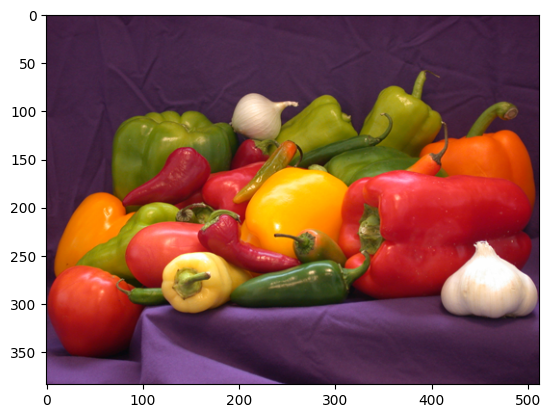

In [5]:
import requests
from PIL import Image
from io import BytesIO

from matplotlib.colors import ListedColormap

url = "https://raw.githubusercontent.com/YugeTen/Computer-vision-CLAB2/master/peppers.png"

response = requests.get(url)
peppers_image = Image.open(BytesIO(response.content))
peppers = np.array(peppers_image)

print(peppers.shape)
h, w = peppers.shape[:2]

plt.imshow(peppers)
plt.show()

This image of the pepper is stored as a numpy array of size (384, 512, 3). What does this shape correspond to?

Each pixel in this image will be a single data point. There are 384 x 512 pixels in this image.

 - 384 is the height of the image or the y-dimension. 
 - 512 is the height of the image or the x-dimension.
 
 NOTE: For images, the origin is in the upper left corner and the y-coordinate increases downwards. This convention parallels the indices of a matrix.

 The last dimension (3) corresponds to the color of the pixel as R, G, and B values.

 So each pixel has five features: y-position, x-position, R, G, B

 Below we take a closer look.

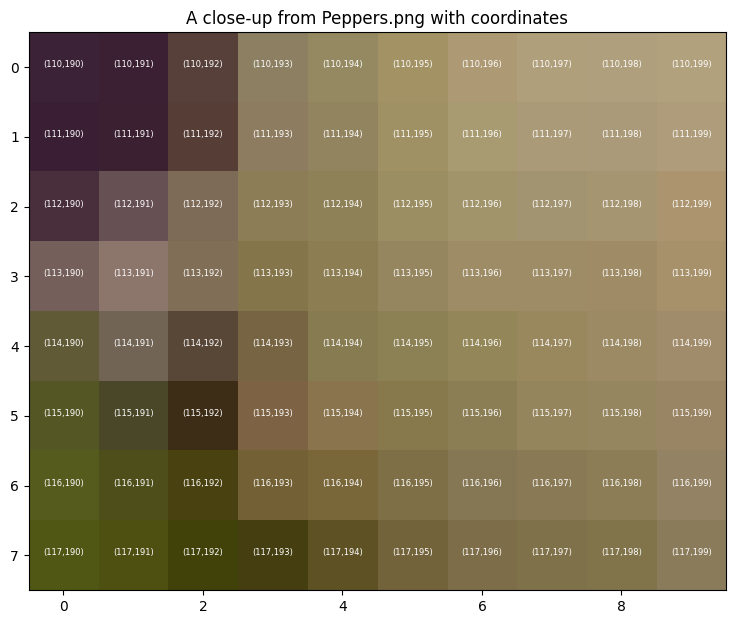

In [6]:
# Create a meshgrid of x and y coordinates for the image dimensions
x_coords, y_coords = np.meshgrid(range(w), range(h))

# Flatten the meshgrid arrays to create a list of coordinates
x_coords_flat = x_coords.flatten()
y_coords_flat = y_coords.flatten()

x_min, x_max = 190, 200
y_min, y_max = 110, 118

fig, ax = plt.subplots(1,1, figsize = (9,9))
plt.imshow(peppers[y_min:y_max, x_min:x_max,:])

for m, y in enumerate(range(y_min, y_max)):
    for n, x in enumerate(range(x_min, x_max)):
        plt.text(n, m, f'({y},{x})', 
                 fontsize = 6, color ='white', ha = 'center')
        
plt.title('A close-up from Peppers.png with coordinates')
plt.show()



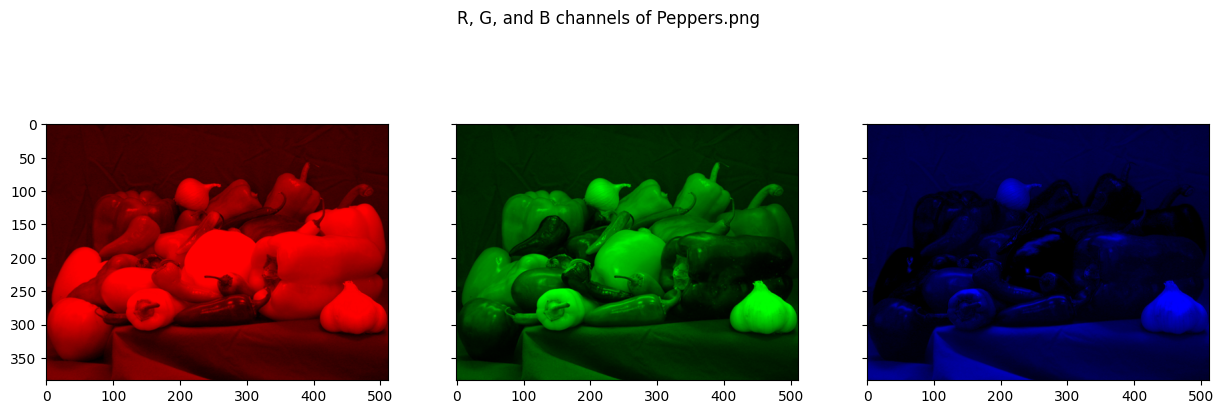

In [7]:
fig, ax = plt.subplots(1, 3, figsize = (15,5),sharey=True)

zeros = np.zeros(256)
ones = np.ones(256)
color_range = np.linspace(0,1, 256, endpoint=True)

reds =ListedColormap(np.vstack([color_range, zeros, zeros]).transpose())
greens =ListedColormap(np.vstack([zeros, color_range, zeros]).transpose())
blues =ListedColormap(np.vstack([zeros, zeros, color_range]).transpose())

RGB = [reds,greens,blues]

for n in range(3):
    ax[n].imshow(peppers[:,:,n], cmap = RGB[n])

plt.suptitle('R, G, and B channels of Peppers.png')   
plt.show()


Now we'll create a dataframe of these data.

In [8]:
peppers_dict = dict(
    R = peppers[:,:,0].flatten(),
    G = peppers[:,:,1].flatten(),
    B = peppers[:,:,2].flatten(),
    x = x_coords.flatten(),
    y = y_coords.flatten()   
)


peppers_dict
peppers_df = pd.DataFrame(peppers_dict)
peppers_df['RGB'] = peppers_df.apply(lambda row: [row['R']/255, row['G']/255, row['B']/255], axis=1)
peppers_df.head()

,R,G,B,x,y,RGB
0,62,29,64,0,0,"[0.24313725490196078, 0.11372549019607843, 0.2..."
1,63,31,64,1,0,"[0.24705882352941178, 0.12156862745098039, 0.2..."
2,63,34,64,2,0,"[0.24705882352941178, 0.13333333333333333, 0.2..."
3,65,30,60,3,0,"[0.2549019607843137, 0.11764705882352941, 0.23..."
4,66,27,59,4,0,"[0.25882352941176473, 0.10588235294117647, 0.2..."


### Example: Extracting a Color Palette from a Photo

If you look at the photograph, you see various shades of reds, yellows, greens, whites, and purples. A color palette represents the colors in the image as a discrete set of representative colors. To build this palette, we'll apply K-means to the color of each pixel and extract the centroids.

Let's see.

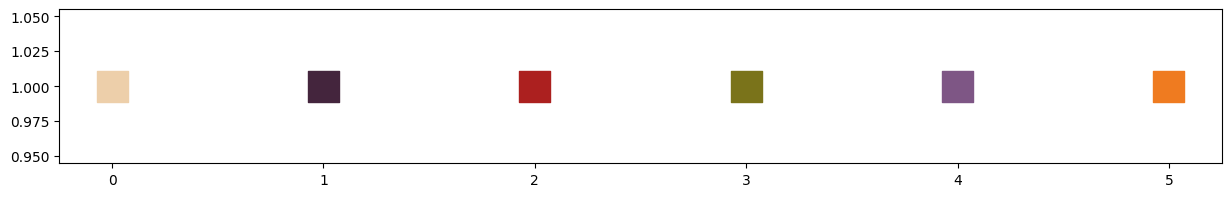

In [9]:
X = peppers_df[['R', 'G', 'B']]

n_colors = 6
km = KMeans(n_clusters = n_colors)
km.fit(X)

labels = km.labels_
centroids = km.cluster_centers_

centroids
fig, ax = plt.subplots(1,1, figsize = (15, 2))
plt.scatter(x = range(n_colors), y = np.ones(n_colors), c = centroids/255,
            marker = 's', s = 500)
plt.show()

In [10]:
peppers_df['label'] = labels
peppers_df['label'].value_counts()

label
1    99485
2    29213
3    24809
5    22848
4    11815
0     8438
Name: count, dtype: int64

In [11]:
color_palette = pd.DataFrame({'label':range(n_colors), 'CR': centroids[:,0]/255, 'CG': centroids[:,1]/255, 'CB':centroids[:,2]/255})
color_palette

,label,CR,CG,CB
0,0,0.928569,0.810076,0.667198
1,1,0.265641,0.146196,0.238846
2,2,0.675812,0.124248,0.121607
3,3,0.477924,0.449846,0.100019
4,4,0.494229,0.335703,0.520272
5,5,0.936374,0.482551,0.125319


Now we can merge our pixel labels to the palette colors, assigning to each pixel the palette color it's nearest too. If we again show the image replacing each pixel color with the associated palette color, we get a posterizing effect (like would be done for screen printing).

In [12]:
peppers_df = peppers_df.merge(color_palette, how = 'left', on = 'label')
peppers_df


,R,G,B,x,y,RGB,label,CR,CG,CB
0,62,29,64,0,0,"[0.24313725490196078, 0.11372549019607843, 0.2...",1,0.265641,0.146196,0.238846
1,63,31,64,1,0,"[0.24705882352941178, 0.12156862745098039, 0.2...",1,0.265641,0.146196,0.238846
2,63,34,64,2,0,"[0.24705882352941178, 0.13333333333333333, 0.2...",1,0.265641,0.146196,0.238846
3,65,30,60,3,0,"[0.2549019607843137, 0.11764705882352941, 0.23...",1,0.265641,0.146196,0.238846
4,66,27,59,4,0,"[0.25882352941176473, 0.10588235294117647, 0.2...",1,0.265641,0.146196,0.238846
...,...,...,...,...,...,...,...,...,...,...
196603,43,20,44,507,383,"[0.16862745098039217, 0.0784313725490196, 0.17...",1,0.265641,0.146196,0.238846
196604,41,19,39,508,383,"[0.1607843137254902, 0.07450980392156863, 0.15...",1,0.265641,0.146196,0.238846
196605,40,20,41,509,383,"[0.1568627450980392, 0.0784313725490196, 0.160...",1,0.265641,0.146196,0.238846
196606,42,21,45,510,383,"[0.16470588235294117, 0.08235294117647059, 0.1...",1,0.265641,0.146196,0.238846


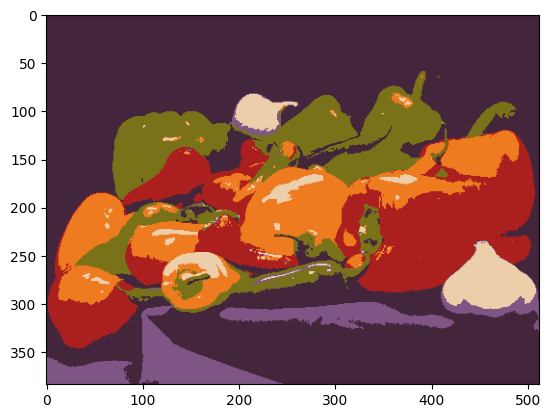

In [13]:

peppers_poster = peppers_df[['x','y','CR','CG','CB']]

reshaped_image = peppers_poster[['CR', 'CG', 'CB']].values.reshape(h, w, 3)
plt.imshow(reshaped_image)
plt.show()



### Example: Segmenting Objects in an Image (kinda)

Image segmentation refers to the process of partitioning an image into the objects in the image. We'll attempt an image segmentation by incorporating pixel position and pixel color. The idea is that an object is represented by a blob of pixels that are near each other and of similar color.

In [14]:
peppers_df = peppers_df[['x', 'y', 'R', 'G', 'B']]
peppers_df

,x,y,R,G,B
0,0,0,62,29,64
1,1,0,63,31,64
2,2,0,63,34,64
3,3,0,65,30,60
4,4,0,66,27,59
...,...,...,...,...,...
196603,507,383,43,20,44
196604,508,383,41,19,39
196605,509,383,40,20,41
196606,510,383,42,21,45


In [15]:
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler()
peppers_scaled = mm.fit_transform(peppers_df)

/var/folders/qm/g7x838zs775f4j_5s231csf80000gn/T/ipykernel_28841/4191165465.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peppers_df['label'] = labels


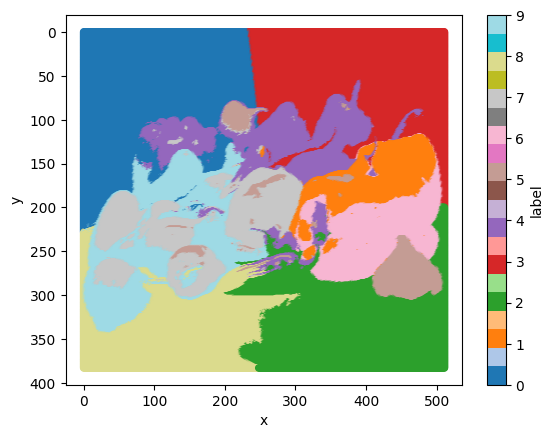

In [16]:
n_objects = 10
km = KMeans(n_clusters = n_objects)

km.fit(peppers_scaled)

labels = km.labels_
centroids = km.cluster_centers_

peppers_df['label'] = labels
peppers_df.plot.scatter(x = 'x', y = 'y', c = 'label', cmap = 'tab20')
plt.gca().yaxis.set_inverted(True)
plt.show()